In [6]:
pip install python-docx

  Obtaining dependency information for python-docx from https://files.pythonhosted.org/packages/3e/3d/330d9efbdb816d3f60bf2ad92f05e1708e4a1b9abe80461ac3444c83f749/python_docx-1.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.9.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/244.3 kB ? eta -:--:--
   --- ----------------------------------- 20.5/244.3 kB 640.0 kB/s eta 0:00:01
   --------------- ------------------------ 92.2/244.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 244.3/244.3 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
Note: you may need to restart the kernel to use updated pack

In [2]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import time
import datetime

import seaborn as sns

from docx import Document
from docx.shared import Inches
import os

# 1. Recopilación de fuentes y categorización

In [1]:
# #rutas (ALEJANDO - PERSONAL)

# # Ruta base donde se encuentran los archivos shapefile
# base_path = r"C:\Users\Alejandro\Downloads\DATA\SHP"

# output_path_excel = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_2020.xlsx"
# output_path_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

#rutas (ALEJANDO - SSD)

# Ruta base donde se encuentran los archivos shapefile
base_path = r"Z:\VOCES\DATA\SHP"

output_path_excel = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_2020.xlsx"
output_path_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

In [4]:
#1.2 Carga de capas de información puntual, de ambos años, en Jupyter

# Lista para almacenar los GeoDataFrames de cada estado
gdfs = []

# Recorrer los números de estado (del 01 al 32)
for i in range(1, 33):
    # Formatear el número del estado como 'XX' (ejemplo: 01, 02, 03...32)
    state_code = f"{i:02d}"
    # Crear la ruta completa del archivo shapefile
    file_path = os.path.join(base_path, f"{state_code}sip.shp")
    
    # Cargar el shapefile y añadirlo a la lista
    gdf_state = gpd.read_file(file_path)
    gdfs.append(gdf_state)

# Unir todos los GeoDataFrames en uno solo
gdf_2020 = gpd.pd.concat(gdfs, ignore_index=True)

# Verificar la unión exitosa
print(f"Total de registros en el archivo unido: {len(gdf_2020)}")

#guardar en gpkg
gdf_2020.to_file(output_path_gpkg, layer='Eq_full_2020')



#1.3 Desplegado de campos únicos

# Agrupar por 'GEOGRÁFICO' y obtener los valores únicos de 'TIPO' para cada uno
diccionario_geografico_tipo = {}

# Recorrer cada valor único de GEOGRAFICO
for geografico in gdf_2020['GEOGRAFICO'].unique():
    # Filtrar los datos correspondientes al valor de 'GEOGRAFICO' actual
    subset = gdf_2020[gdf_2020['GEOGRAFICO'] == geografico]
    
    # Obtener los valores únicos de 'TIPO' asociados a este 'GEOGRAFICO'
    tipos = subset['TIPO'].unique()
    
    # Añadir al diccionario, si no tiene subniveles, ponemos una lista vacía
    diccionario_geografico_tipo[geografico] = list(tipos) if len(tipos) > 0 else []

# Mostrar el diccionario creado
for geo, tipos in diccionario_geografico_tipo.items():
    print(f"{geo}: {tipos}")


#1.4 Desplegado de valores únicos en campos X e Y
#1.5 Exportación de ambas listas en .xlsx

# Convertir el diccionario en un DataFrame para exportar a Excel
data = []

# Recorrer el diccionario y estructurarlo en filas
for geografico, tipos in diccionario_geografico_tipo.items():
    if tipos:  # Si hay subniveles en 'TIPO'
        for tipo in tipos:
            data.append([geografico, tipo])
    else:
        data.append([geografico, None])  # Si no hay subniveles, ponemos 'None' en 'TIPO'

# Crear DataFrame
df_diccionario = pd.DataFrame(data, columns=['GEOGRAFICO', 'TIPO'])

# Exportar a archivo Excel
df_diccionario.to_excel(output_path_excel, index=False)

print(f"Diccionario exportado exitosamente a {output_path_excel}")


Total de registros en el archivo unido: 440164
Centro de Asistencia Médica: ['Centro de Salud', 'Hospital', 'Centro de Rehabilitación']
Escuela: ['Primaria', 'Preescolar', 'Secundaria', 'Medio Superior', 'Superior', 'Mixto']
Templo: ['No Aplica']
Cementerio: ['No Aplica']
Pozo: ['Agua', 'Petróleo', 'Gas']
Instalación Deportiva o Recreativa: ['Cancha', 'Parque', 'Unidad Deportiva', 'Jardín', 'Lienzo Charro', 'Áreas Verdes', 'Estadio', 'Plaza de Toros', 'Campo de Golf', 'Velódromo', 'Balneario', 'Hipódromo', 'Galgódromo', 'Zoológico', 'Alberca Olímpica', 'Campo de Tiro', 'Autódromo', 'Acuario']
Tanque de Agua: ['Tanque Elevado', 'Caja de Agua']
Instalación Gubernamental: ['Palacio de Gobierno', 'Palacio Municipal']
Mercado: ['No Aplica']
Plaza: ['No Aplica']
Instalación Diversa: ['Monumento u Obelisco', 'Silo', 'Planta de Tratamiento de Agua', 'Gasolinera', 'Museo', 'Centro de Investigación', 'Teatro', 'Edificación Cultural', 'Centro de Espectáculos', 'Cine', 'Estación de Gas', 'Observat

# 2. Ponderación y niveles de servicio

In [5]:
# #rutas (ALEJANDRO - PERSONAL)
# equipamientos_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"
# Diccionario_comentado = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_pond_2020.xlsx"

#rutas (ALEJANDRO - SSD)
equipamientos_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"
Diccionario_comentado = r"Z:\VOCES\DATA\\Tratados\NAC\EQUIPAMIENTOS\Diccionario_pond_2020.xlsx"

In [6]:
# Cargar el diccionario actualizado con las nuevas columnas
diccionario = pd.read_excel(Diccionario_comentado)

# Unir el diccionario con el geodataframe gdf_2020 (asegurarse de que haya un campo en común, por ejemplo 'GEOGRAFICO' y 'TIPO')
gdf_2020 = gdf_2020.merge(diccionario, on=['GEOGRAFICO', 'TIPO'], how='left')

# Filtrar por categorías y exportar a archivos individuales

# Crear una lista de categorías
categorias = ['Educación', 'Salud', 'Recreación', 'Servicios']

# Crear y exportar un GeoDataFrame por cada categoría a una capa dentro del geopackage
for categoria in categorias:
    # Filtrar los equipamientos de la categoría actual
    gdf_categoria = gdf_2020[gdf_2020['CATEGORIA'] == categoria]
    
    # Exportar la categoría como una nueva capa en el geopackage
    gdf_categoria.to_file(equipamientos_gpkg, layer=categoria, driver="GPKG")
    
    print(f"Exportado: {categoria} a la capa {categoria} en el geopackage")

Exportado: Educación a la capa Educación en el geopackage
Exportado: Salud a la capa Salud en el geopackage
Exportado: Recreación a la capa Recreación en el geopackage
Exportado: Servicios a la capa Servicios en el geopackage


# 3. Trabajo a nivel manzana

In [2]:
# # #rutas (ALEJANDRO - PERSONAL)
# manzanas_gpkg_path = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\MZ\Manzanas_NAC.gpkg"
# equipamientos_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

#rutas (ALEJANDRO - SSD)
manzanas_gpkg_path = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC.gpkg"
equipamientos_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

In [ ]:
#3.1: Cargar el archivo de manzanas

# Cargar el archivo de manzanas
gdf_manzanas = gpd.read_file(manzanas_gpkg_path, layer='Mzn_SubTipologias_ue')


# Crear un buffer de 2 metros alrededor de las manzanas
gdf_manzanas['buffer_2m'] = gdf_manzanas.geometry.buffer(2)

# Establecer el buffer como la geometría activa
gdf_manzanas = gdf_manzanas.set_geometry('buffer_2m')

# Inicializar las columnas para contar equipamientos en cada categoría
gdf_manzanas['num_edu'] = 0
gdf_manzanas['num_sal'] = 0
gdf_manzanas['num_rec'] = 0
gdf_manzanas['num_ser'] = 0

# Lista de categorías y sus respectivas columnas de conteo
categorias = {
    'Educación': 'num_edu',
    'Salud': 'num_sal',
    'Recreación': 'num_rec',
    'Servicios': 'num_ser'
}

# Cargar cada capa de equipamientos desde el geopackage y contar los elementos por manzana
for categoria, columna_conteo in categorias.items():
    # Cargar la capa correspondiente desde el geopackage
    gdf_categoria = gpd.read_file(equipamientos_gpkg, layer=categoria)
    
    # Realizar un join espacial entre los buffers de manzanas y los equipamientos de la categoría
    joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', op='contains')
    
    # Contar los equipamientos de la categoría por cada manzana
    gdf_manzanas[columna_conteo] = joined.groupby(joined.index)['index_right'].count()

    print(f"Conteo completado para la categoría: {categoria}")

#borrar columna del buffer
gdf_manzanas = gdf_manzanas.drop(columns=['buffer_2m'])

# Establecer el buffer como la geometría activa
gdf_manzanas = gdf_manzanas.set_geometry('geometry')

#Guardar la capa resultante en un archivo .gpkg
gdf_manzanas.to_file(manzanas_gpkg_path, layer='Mzn_SubTipologias_eq', driver="GPKG")

In [13]:
#3.3: Aplicación de radios de influencia para los equipamientos

# Definir los valores de radio en metros para cada nivel de servicio
radio_niveles = {1: 1600, 2: 4800, 3: 14400}  # 1 km, 5 km, 12 km

# Define el CRS proyectado que deseas utilizar
CRS_PROYECTADO = 'EPSG:6372' 

# Crear una lista de categorías
categorias = ['Educación', 'Salud', 'Recreación', 'Servicios']

# Cargar cada capa de equipamientos desde el geopackage y contar los elementos por manzana
for categoria in categorias:
    # Cargar la capa correspondiente desde el geopackage
    gdf_categoria = gpd.read_file(equipamientos_gpkg, layer=categoria)

    # Proyecta el GeoDataFrame a un CRS proyectado
    # gdf_categoria = gdf_categoria.set_crs(CRS_PROYECTADO)
    gdf_categoria = gdf_categoria.to_crs(CRS_PROYECTADO)

    # Crear los buffers basados en el nivel de servicio (campo 'RADIO')
    gdf_categoria['buffer_influencia'] = gdf_categoria.apply(lambda row: row.geometry.buffer(radio_niveles[row['RADIO']]), axis=1)
    
    # Establecer el buffer como la geometría activa
    gdf_categoria = gdf_categoria.set_geometry('buffer_influencia')
    
    #borrar columna del buffer
    gdf_categoria = gdf_categoria.drop(columns=['geometry'])

    # # Proyecta el GeoDataFrame a un CRS proyectado
    # gdf_categoria = gdf_categoria.to_crs(CRS_PROYECTADO)

    #Guardar la capa en un archivo
    gdf_categoria.to_file(equipamientos_gpkg, layer=f"{categoria}_Buffer", driver="GPKG")

    print(f"Búffer completado para la categoría: {categoria}")


Búffer completado para la categoría: Educación
Búffer completado para la categoría: Salud
Búffer completado para la categoría: Recreación
Búffer completado para la categoría: Servicios


In [ ]:
############## Siguiente proceso se realiza mediante QGIS

# Cargar la capa de manzanas, y las 4 capas de búffers de equipamientos

# Utilizar Join atributtes by location (summary), para sumar cada categoría a las manzanas, de forma consecuente

# Refactorizar para renombrar los campos creados

# Guardar dentro del geopackage de la base de datos

In [ ]:
# # 3.4: Sumar los valores de ponderación por manzana

# # Inicializar las columnas de importancia por categoría
# gdf_manzanas['IMP_EDU'] = 0
# gdf_manzanas['IMP_SAL'] = 0
# gdf_manzanas['IMP_REC'] = 0
# gdf_manzanas['IMP_SER'] = 0

# # Diccionario que asocia las categorías con las columnas de importancia
# categorias = {
#     'Educación': 'IMP_EDU',
#     'Salud': 'IMP_SAL',
#     'Recreación': 'IMP_REC',
#     'Servicios': 'IMP_SER'
# }

# print(f'1 - {datetime.datetime.now().time()}')

# # Dividir el GeoDataFrame de manzanas en partes más pequeñas
# chunk_size = 20000  # Ajusta el tamaño según la memoria disponible
# manzanas_chunks = np.array_split(gdf_manzanas, len(gdf_manzanas) // chunk_size)

# # Procesar cada bloque de manzanas y sumarle la importancia de los equipamientos que intersectan
# result_chunks = []

# print(f'2 - {datetime.datetime.now().time()}')

# for i, chunk in enumerate(manzanas_chunks):
#     print(f"Procesando bloque {i+1} de {len(manzanas_chunks)}")

#     # Copiar el chunk para no modificar el original
#     chunk_copy = chunk.copy()
    
#     for categoria, columna_importancia in categorias.items():
        
#         # Join espacial entre el chunk de manzanas y los equipamientos por categoría usando el buffer de influencia
#         joined = gpd.sjoin(
#             chunk_copy, 
#             gdf_categoria[['buffer_influencia', 'IMPORTANCIA']], 
#             how='left', 
#             predicate='intersects',
#             lsuffix='mz', 
#             rsuffix='eq'
#         )
        
#         # Sumar la importancia de los equipamientos que caen dentro de cada manzana
#         sum_importancia = joined.groupby(joined.index)['IMPORTANCIA'].sum()
        
#         # Actualizar la columna de importancia en el chunk original
#         chunk_copy[columna_importancia] += chunk_copy.index.map(sum_importancia).fillna(0)

#     # Añadir el chunk procesado a la lista de resultados
#     result_chunks.append(chunk_copy)

# print(f'3 - {datetime.datetime.now().time()}')

# # Concatenar todos los chunks procesados para obtener el GeoDataFrame final
# gdf_manzanas_final = pd.concat(result_chunks)

# # Revisar el resultado
# gdf_manzanas_final.head()


In [3]:
# 3.5: Visualización estadística de los valores de importancia por categoría

#rutas (ALEJANDRO - SSD)
manzanas_gpkg_path = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC_ImpEq.gpkg"

# Cargar el archivo de manzanas
gdf_manzanas = gpd.read_file(manzanas_gpkg_path, layer='Mzn_Subtipologias_UeEq')


       IMP_EDU  IMP_SAL  IMP_REC  IMP_SER
count  1198479  1189687  1174970  1197353
mean       368       55       83       96
std        350       50      146       89
min          3        1        1        1
25%        123       20       14       28
50%        270       39       37       60
75%        483       71       91      152
max       2274      331     1411      586


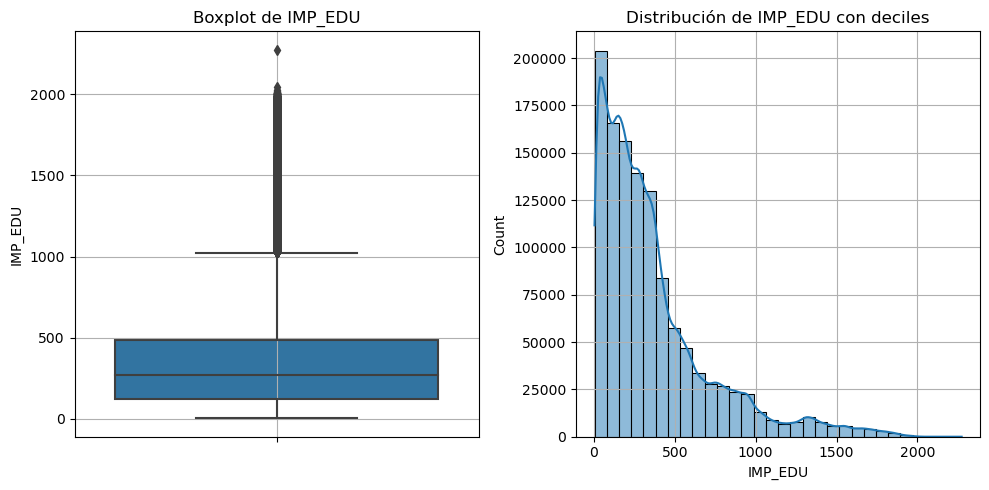

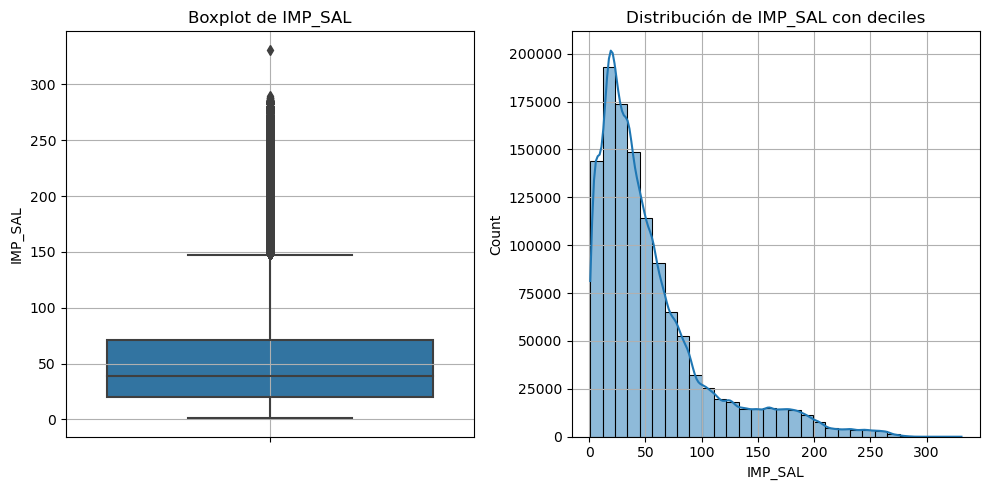

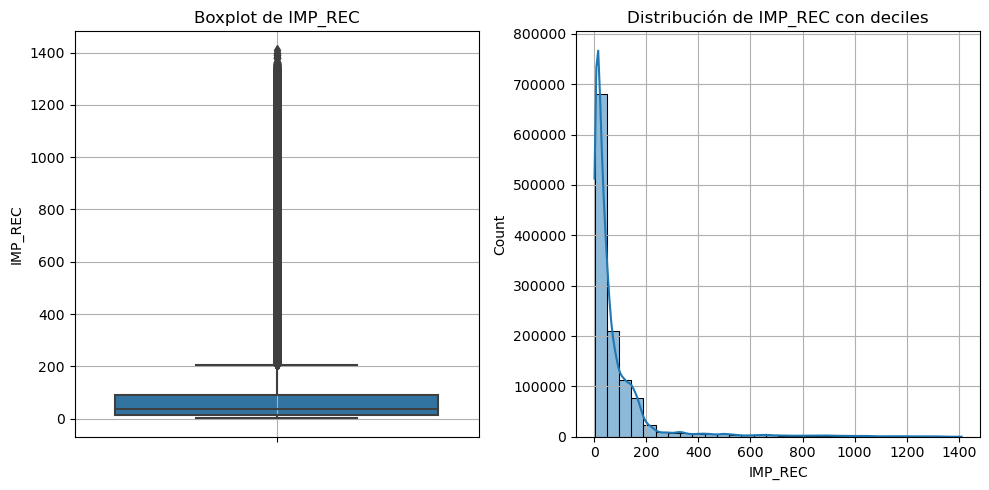

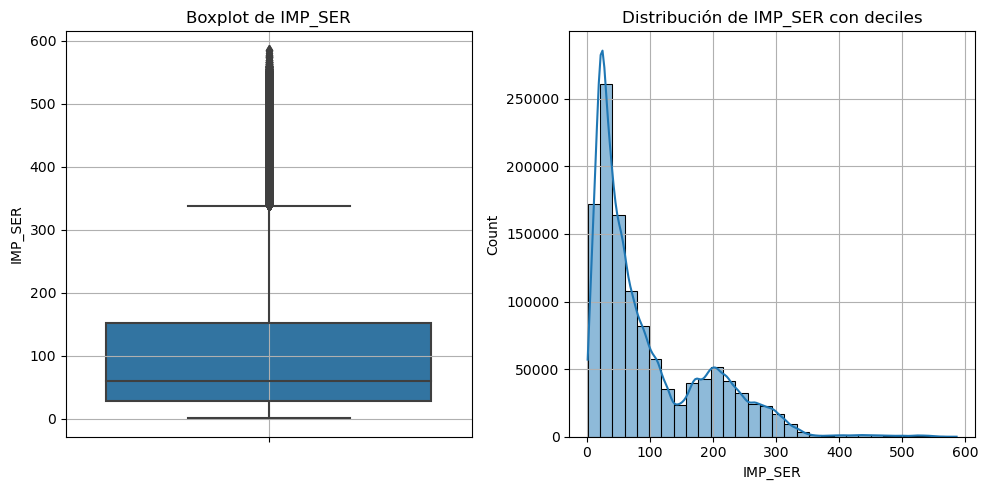

In [5]:
# Configurar para que los valores se muestren sin notación exponencial
pd.set_option('display.float_format', '{:.0f}'.format)

# Columnas de interés
columnas_interes = ['IMP_EDU', 'IMP_SAL', 'IMP_REC', 'IMP_SER']

# Mostrar estadísticas descriptivas sin notación exponencial
stats = gdf_manzanas[columnas_interes].describe()
print(stats)

# Graficar boxplot y distribución para cada columna de interés
for columna in columnas_interes:
    plt.figure(figsize=(10, 5))
    
    # Gráfico de Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=gdf_manzanas, y=columna)
    plt.title(f'Boxplot de {columna}')
    plt.grid(True)

    # Gráfico de Distribución
    plt.subplot(1, 2, 2)
    sns.histplot(gdf_manzanas[columna], kde=True, bins=30)
    
    # Calcular y agregar líneas en los deciles
    deciles = np.percentile(gdf_manzanas[columna], [10, 20, 30, 40, 50, 60, 70, 80, 90])
    for decile in deciles:
        plt.axvline(decile, color='red', linestyle='--', linewidth=1)
    
    plt.title(f'Distribución de {columna} con deciles')
    plt.grid(True)
    
    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()


In [10]:
# Configurar para que los valores se muestren sin notación exponencial
pd.set_option('display.float_format', '{:.0f}'.format)

# Columnas de interés
columnas_interes = ['IMP_EDU', 'IMP_SAL', 'IMP_REC', 'IMP_SER']

#llenar nulos de columans con 0
gdf_manzanas[columnas_interes] = gdf_manzanas[columnas_interes].fillna(0)

# Mostrar estadísticas descriptivas sin notación exponencial
stats = gdf_manzanas[columnas_interes].describe()
print(stats)

# Crear el documento Word
doc = Document()
doc.add_heading('Análisis Estadístico', level=1)

# Añadir las estadísticas descriptivas al documento
doc.add_heading('Estadísticas Descriptivas', level=2)
doc.add_paragraph(stats.to_string())

# Graficar boxplot y distribución para cada columna de interés y añadirlas al documento
for columna in columnas_interes:
    # Crear la figura
    plt.figure(figsize=(10, 5))
    
    # Gráfico de Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=gdf_manzanas, y=columna)
    plt.title(f'Boxplot de {columna}')
    plt.grid(True)
    boxplot_path = f'{columna}_boxplot.png'
    plt.savefig(boxplot_path)

    # Gráfico de Distribución
    plt.subplot(1, 2, 2)
    sns.histplot(gdf_manzanas[columna], kde=True, bins=30)
    
    # Calcular y agregar líneas en los deciles
    deciles = np.percentile(gdf_manzanas[columna], [10, 20, 30, 40, 50, 60, 70, 80, 90])
    for decile in deciles:
        plt.axvline(decile, color='red', linestyle='--', linewidth=1)
    
    plt.title(f'Distribución de {columna} con deciles')
    plt.grid(True)
    distplot_path = f'{columna}_distplot.png'
    plt.savefig(distplot_path)
    plt.close()

    # Añadir gráficos al documento
    doc.add_heading(f'Gráficos de {columna}', level=2)
    # doc.add_paragraph('Boxplot:')
    # doc.add_picture(boxplot_path, width=Inches(5))
    doc.add_paragraph('Distribución:')
    doc.add_picture(distplot_path, width=Inches(7))

    # Eliminar las imágenes temporales
    os.remove(boxplot_path)
    os.remove(distplot_path)

# Guardar el documento
doc.save(r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Eq_Estadisticas.docx")

print("El archivo Word ha sido creado exitosamente como 'Eq_Estadisticas.docx'")


       IMP_EDU  IMP_SAL  IMP_REC  IMP_SER
count  1200165  1200165  1200165  1200165
mean       368       55       81       96
std        350       50      145       89
min          0        0        0        0
25%        123       20       13       28
50%        270       39       36       59
75%        480       70       89      152
max       2274      331     1411      586


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

El archivo Word ha sido creado exitosamente como 'Eq_Estadisticas.docx'


       IMP_EDU  IMP_SAL  IMP_REC  IMP_SER
count  1200165  1200165  1200165  1200165
mean       368       55       81       96
std        350       50      145       89
min          0        0        0        0
25%        123       20       13       28
50%        270       39       36       59
75%        480       70       89      152
max       2274      331     1411      586


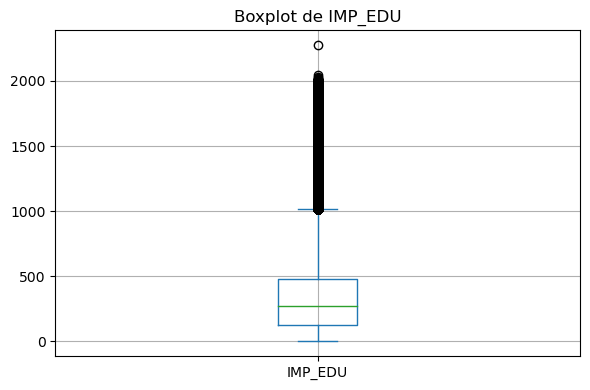

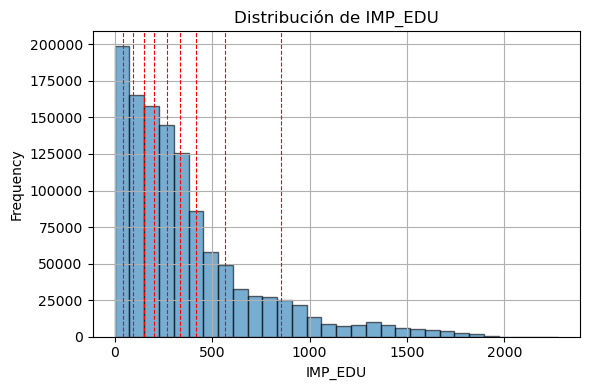

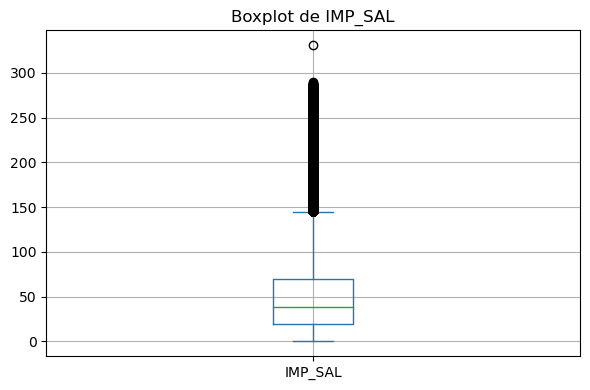

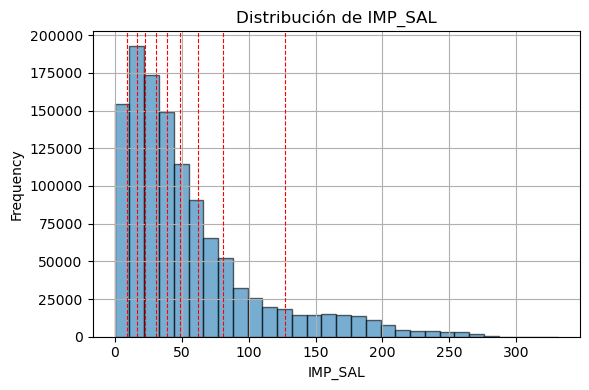

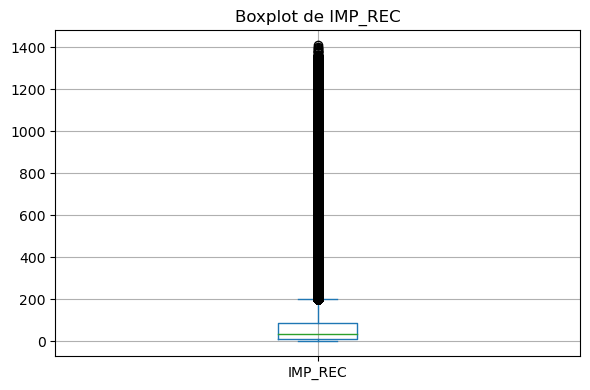

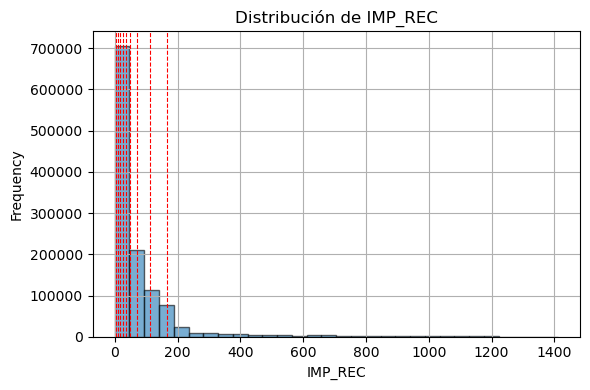

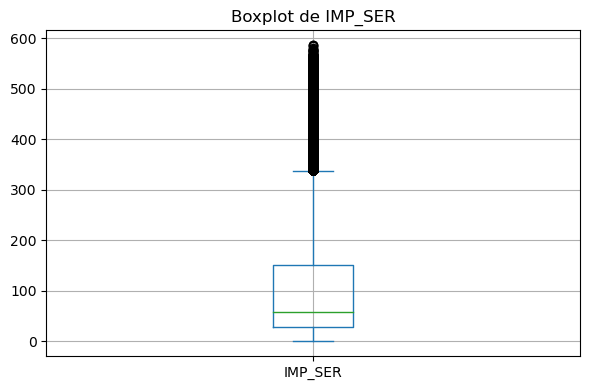

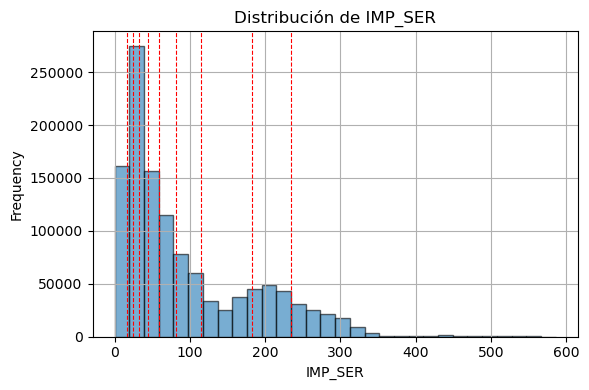

El archivo Word ha sido creado exitosamente como 'Eq_Estadisticas.docx'


In [19]:
# Supongamos que tus datos están en un DataFrame df y que tus columnas de interés son las siguientes:
columnas_interes = ['IMP_EDU', 'IMP_SAL', 'IMP_REC', 'IMP_SER']

# Reemplazar nulos con 0 en las columnas de interés
gdf_manzanas[columnas_interes] = gdf_manzanas[columnas_interes].fillna(0)

# Mostrar estadísticas descriptivas sin notación exponencial
stats = gdf_manzanas[columnas_interes].describe()
print(stats)

# Traducir los nombres de las filas
stats.rename(index={
    'count': 'conteo',
    'mean': 'promedio',
    'std': 'desviación estándar',
    'min': 'mínimo',
    '25%': '25%',
    '50%': 'mediana (50%)',
    '75%': '75%',
    'max': 'máximo'
}, inplace=True)

# Crear un documento de Word
doc = Document()
doc.add_heading('Estadísticas y Visualización de Importancia', level=1)

# Añadir las estadísticas descriptivas como tabla
doc.add_heading('Estadísticas Descriptivas', level=2)

# Añadir la tabla al documento
table = doc.add_table(rows=1, cols=len(stats.columns) + 1)
table.style = 'Table Grid'

# Agregar encabezados a la tabla
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Estadística'
for idx, column in enumerate(stats.columns):
    hdr_cells[idx + 1].text = column

# Agregar los datos de las estadísticas a la tabla
for index, row in stats.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(index)
    for idx, value in enumerate(row):
        row_cells[idx + 1].text = f"{value:,.2f}"  # Formato para evitar notación exponencial y limitar a dos decimales

# Iterar sobre las columnas de interés
for columna in columnas_interes:
    
    # Crear boxplot
    plt.figure(figsize=(6, 4))
    gdf_manzanas[columna].plot(kind='box')
    plt.title(f'Boxplot de {columna}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{columna}_boxplot.png')  # Guardar la gráfica como imagen
    doc.add_picture(f'{columna}_boxplot.png', width=Inches(6))  # Agregar la imagen al documento
    plt.show()  # Mostrar la gráfica en el entorno de Python
    
    # Crear gráfico de distribución con líneas de deciles
    plt.figure(figsize=(6, 4))
    gdf_manzanas[columna].plot(kind='hist', bins=30, alpha=0.6, edgecolor='black')
    for decil in range(1, 10):
        decil_value = gdf_manzanas[columna].quantile(decil / 10)
        plt.axvline(decil_value, color='red', linestyle='--', linewidth=0.8)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{columna}_distribution.png')  # Guardar la gráfica como imagen
    doc.add_picture(f'{columna}_distribution.png', width=Inches(6))  # Agregar la imagen al documento
    plt.show()  # Mostrar la gráfica en el entorno de Python

# Guardar el documento
doc.save(r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Eq_Estadisticas.docx")
print("El archivo Word ha sido creado exitosamente como 'Eq_Estadisticas.docx'")